In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import butter, sosfiltfilt, sosfilt

In [45]:
log_filename = "log005.csv"
df = pd.read_csv("logs/" + log_filename)

In [46]:
print(df.columns)

Index(['t_ms', 't_s', 'seq', 'lis1_x', 'lis1_y', 'lis1_z', 'lis2_x', 'lis2_y',
       'lis2_z', 'mmc_mG_x', 'mmc_mG_y', 'mmc_mG_z', 'angle_raw', 'temp_deciC',
       'temp_C'],
      dtype='str')


In [47]:
def get_spherical(x, y, z):
    r = (x**2 + y**2 + z**2)**0.5
    theta = np.arccos(z / r)  # polar angle
    phi = np.arctan2(y, x)  # azimuthal angle
    return r, theta, phi

accel_spherical = []
accel_cartesian = []
for lis_index in range(2):
    accel_spherical_i = []
    for row in range(len(df)):
        x = df[f"lis{lis_index + 1}_x"][row]
        y = df[f"lis{lis_index + 1}_y"][row]
        z = df[f"lis{lis_index + 1}_z"][row]
        accel_spherical_i.append(get_spherical(x, y, z))
    accel_spherical.append(accel_spherical_i)
    accel_cartesian.append(df[[f"lis{lis_index + 1}_x", f"lis{lis_index + 1}_y", f"lis{lis_index + 1}_z"]].values)

accel_spherical = np.array(accel_spherical)
accel_cartesian = np.array(accel_cartesian)

print(accel_spherical.shape)  # Should be (2, num_rows, 3)
print(accel_cartesian.shape)  # Should be (2, num_rows, 3)



(2, 7108, 3)
(2, 7108, 3)


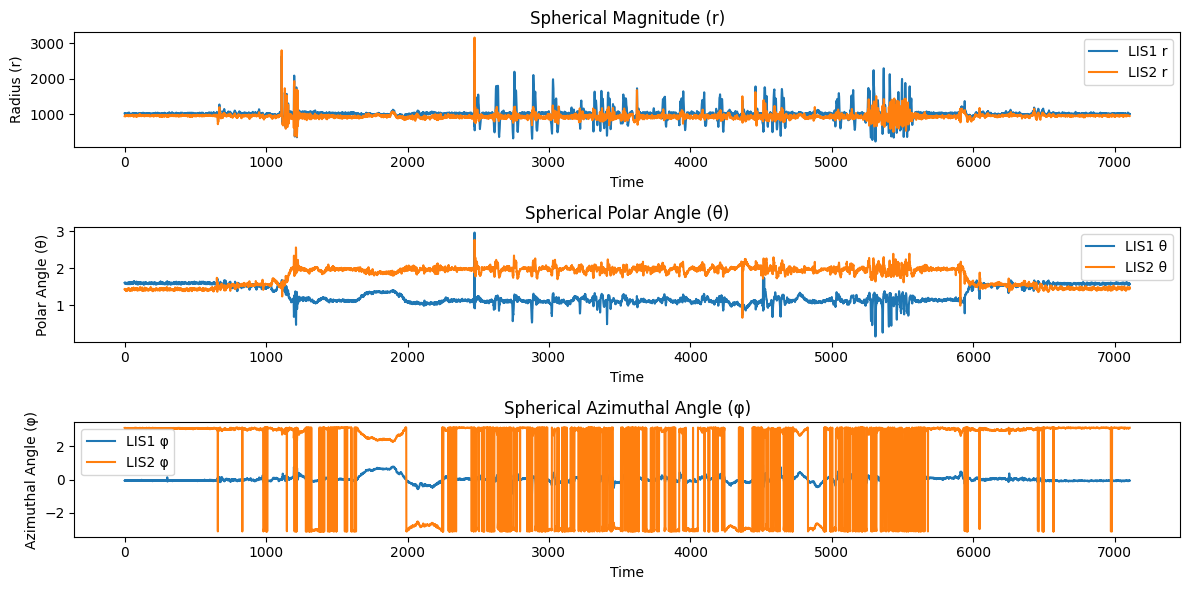

In [48]:
# Plotting the spherical components for both sensors
plt.figure(figsize=(12, 6))
plt.subplot(3, 1, 1)
plt.plot(accel_spherical[0][:, 0], label="LIS1 r")
plt.plot(accel_spherical[1][:, 0], label="LIS2 r")
plt.title("Spherical Magnitude (r)")
plt.xlabel("Time")
plt.ylabel("Radius (r)")
plt.legend()
plt.subplot(3, 1, 2)
plt.plot(accel_spherical[0][:, 1], label="LIS1 θ")
plt.plot(accel_spherical[1][:, 1], label="LIS2 θ")
plt.title("Spherical Polar Angle (θ)")
plt.xlabel("Time")
plt.ylabel("Polar Angle (θ)")
plt.legend()
plt.subplot(3, 1, 3)
plt.plot(accel_spherical[0][:, 2], label="LIS1 φ")
plt.plot(accel_spherical[1][:, 2], label="LIS2 φ")
plt.title("Spherical Azimuthal Angle (φ)")
plt.xlabel("Time")
plt.ylabel("Azimuthal Angle (φ)")
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
# Filter the acceleration data for finding rotation vectors (not for motion)

accel_filtered = np.zeros_like(accel_cartesian)

fc_hz = 20
fs = 100

sos = butter(N=4, Wn=fc_hz, btype="low", fs=fs, output="sos")

for sensor_idx in range(accel_cartesian.shape[0]):
    for axis in range(accel_cartesian.shape[2]):
        axis_data = accel_cartesian[sensor_idx, :, axis]

        # Zero-phase (offline): no group delay, best for analysis/alignment
        filtered_axis = sosfiltfilt(sos, axis_data, axis=0)
        accel_filtered[sensor_idx, :, axis] = filtered_axis


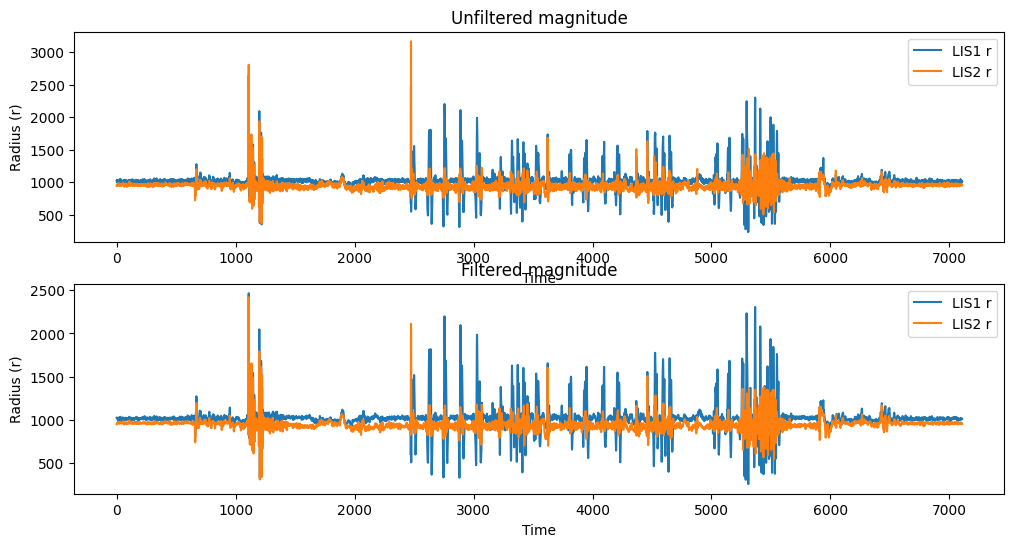

In [50]:
filtered_mag = np.linalg.norm(accel_filtered, axis=2)

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(accel_spherical[0][:, 0], label="LIS1 r")
plt.plot(accel_spherical[1][:, 0], label="LIS2 r")
plt.title("Unfiltered magnitude")
plt.xlabel("Time")
plt.ylabel("Radius (r)")
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(filtered_mag[0][:], label="LIS1 r")
plt.plot(filtered_mag[1][:], label="LIS2 r")
plt.title("Filtered magnitude")
plt.xlabel("Time")
plt.ylabel("Radius (r)")
plt.legend()
plt.show()

In [51]:
# Break XYZ acceleration into chunks
chunk_size = 25 # 0.25s at 100Hz
accel_chunks = []
for i in range(0, accel_filtered.shape[1], chunk_size):
    chunk = accel_filtered[:, i : i + chunk_size, :]
    if chunk.shape[1] == chunk_size:  # Only keep full chunks
        accel_chunks.append(chunk)

print(chunk.shape) # Should be (2, chunk_size, 3)
print(len(accel_chunks)) # Should be num_rows / chunk_size

(2, 8, 3)
284


In [52]:
# 1. find chunks where both accelerometers have little jitter and similar accel

# jitter_thresh = 50 
diff_thresh = 160
conf_thresh = 0.98

jitter_rejects = 0
diff_rejects = 0

still_chunks = []
for chunk in accel_chunks:
    # Calculate the acceleration jitter
    accel_magnitude = np.linalg.norm(chunk, axis=2)  # r component
    mean_accels = []
    for sensor_idx in range(accel_magnitude.shape[0]):
        norm_samples = chunk[sensor_idx] / np.linalg.norm(chunk[sensor_idx], axis=1, keepdims=True)
        mean_vector = np.mean(norm_samples, axis=0)
        conf = np.linalg.norm(mean_vector)
        if conf < conf_thresh:
            jitter_rejects += 1
            break
        # accel_std = np.std(chunk[sensor_idx], axis=0) # Std dev in XYZ axes
        # jitter = np.mean(accel_std)  # Average of XYZ std dev as overall jitter
        # if jitter > jitter_thresh:
        #     jitter_rejects += 1
        #     break
        mean_accel = np.mean(accel_magnitude[sensor_idx])
        mean_accels.append(mean_accel)
    else:
        if (max(mean_accels) - min(mean_accels)) > diff_thresh:
            diff_rejects += 1
            continue
        still_chunks.append(chunk)

print(f"Jitter rejects: {jitter_rejects} Diff rejects: {diff_rejects}")
print(len(still_chunks))
still_chunks = np.array(still_chunks)
print(still_chunks[0].shape)

Jitter rejects: 28 Diff rejects: 6
250
(2, 25, 3)


In [53]:
# Find chunks with angle closest to 90 degrees

def angle_between(a, b):
    a = np.asarray(a, dtype=float)
    b = np.asarray(b, dtype=float)
    na = np.linalg.norm(a)
    nb = np.linalg.norm(b)
    if na == 0 or nb == 0:
        raise ValueError("angle undefined for zero-length vector")

    cos_theta = np.dot(a, b) / (na * nb)
    cos_theta = np.clip(cos_theta, -1.0, 1.0)
    return np.rad2deg(np.arccos(cos_theta)) # degrees

base_sensor_idx = 0

best_angle = 0
best_pair = (0, 0)

for i in range(len(still_chunks)):
    vector_1 = np.mean(still_chunks[i][base_sensor_idx], axis=0)
    for j in range(len(still_chunks)):
        if i == j:
            continue
        vector_2 = np.mean(still_chunks[j][base_sensor_idx], axis=0)
        angle = angle_between(vector_1, vector_2)
        if abs(angle - 90) < abs(best_angle - 90):
            best_angle = angle
            best_pair = (i, j)

print(f"Best pair: {best_pair} with angle {best_angle:.2f} degrees")

mean_vector_1 = np.mean(still_chunks[best_pair[0]], axis=1)
mean_vector_2 = np.mean(still_chunks[best_pair[1]], axis=1)
# Dimensions should be (2, 3) for the two sensors and their mean XYZ vectors
mean_vectors = np.array([mean_vector_1, mean_vector_2])
print(mean_vectors.shape)
print(f"Mean vector 1: {mean_vector_1}, Mean vector 2: {mean_vector_2}")

Best pair: (74, 81) with angle 62.34 degrees
(2, 2, 3)
Mean vector 1: [[ 774.88  677.16  196.4 ]
 [-683.92  692.52 -291.12]], Mean vector 2: [[ 832.12 -355.36  487.72]
 [-764.12 -389.88 -344.96]]


In [54]:
# still_chunks shape: (Nchunks, 2, 25, 3)
# sensor index: 0 = sensor1, 1 = sensor2
s1 = still_chunks[:, 0, :, :]  # (N,25,3)
s2 = still_chunks[:, 1, :, :]  # (N,25,3)

# vec_std1 = np.mean(np.std(s1, axis=1), axis=1)  # (N,)
# vec_std2 = np.mean(np.std(s2, axis=1), axis=1)
# stillness = vec_std1 + vec_std2

# keep = stillness < np.percentile(stillness, 20)   # keep best 20%
# #s1 = s1[keep]
# #s2 = s2[keep]
# print(f"Kept {len(s1)} chunks after stillness filtering")


In [55]:
def normalize_rows(V, eps=1e-9):
    n = np.linalg.norm(V, axis=1, keepdims=True)
    n = np.maximum(n, eps)
    return V / n

def kabsch_rotation(B, A, weights=None):
    """
    Solve R that maps B -> A (i.e., A ≈ R @ B), using Kabsch/Wahba.
    A, B: (K,3) arrays of corresponding vectors
    weights: (K,) optional nonnegative weights
    Returns: (3,3) rotation matrix with det=+1
    """
    if weights is None:
        w = np.ones((B.shape[0],), dtype=float)
    else:
        w = np.asarray(weights, dtype=float)
        w = np.maximum(w, 0)

    # Weighted correlation matrix H = sum_k w_k * A_k * B_k^T
    H = (A * w[:, None]).T @ B

    U, S, Vt = np.linalg.svd(H)
    R = U @ Vt

    # Enforce proper rotation (det=+1), fix reflection if needed
    if np.linalg.det(R) < 0:
        U[:, -1] *= -1
        R = U @ Vt

    return R


In [56]:
# Calculate weights for Kabsch based on stillness or magnitude difference
stillness_weight = True

mag1 = np.linalg.norm(s1, axis=2)  # (N,25)
mag2 = np.linalg.norm(s2, axis=2)  # (N,25)
if stillness_weight:
    # Optional: weights based on how "still" each chunk is (lower std => higher weight)
    # Compute per-chunk std of magnitude for each sensor, then combine
    std1 = np.std(mag1, axis=1)
    std2 = np.std(mag2, axis=1)
    #std1 = np.mean(np.std(s1, axis=1), axis=1)  # (N,)
    #std2 = np.mean(np.std(s2, axis=1), axis=1)
    stillness = std1 + std2
    weights = 1.0 / (stillness + 1e-6)
else:
    # Weight by difference in mean magnitude between sensors (lower diff => higher weight)
    mean_mag1 = np.mean(mag1, axis=1)
    mean_mag2 = np.mean(mag2, axis=1)
    mag_diff = np.abs(mean_mag1 - mean_mag2)
    weights = 1.0 / (mag_diff + 1e-6)


In [57]:
# Normalize XYZ per-sample to remove magnitude/scale bias
s1u = s1 / np.linalg.norm(s1, axis=2, keepdims=True)
s2u = s2 / np.linalg.norm(s2, axis=2, keepdims=True)
# Normalize rows (chunks) of sample-wise means to get unit vectors for Kabsch
A_u = normalize_rows(np.mean(s1u, axis=1))
B_u = normalize_rows(np.mean(s2u, axis=1))

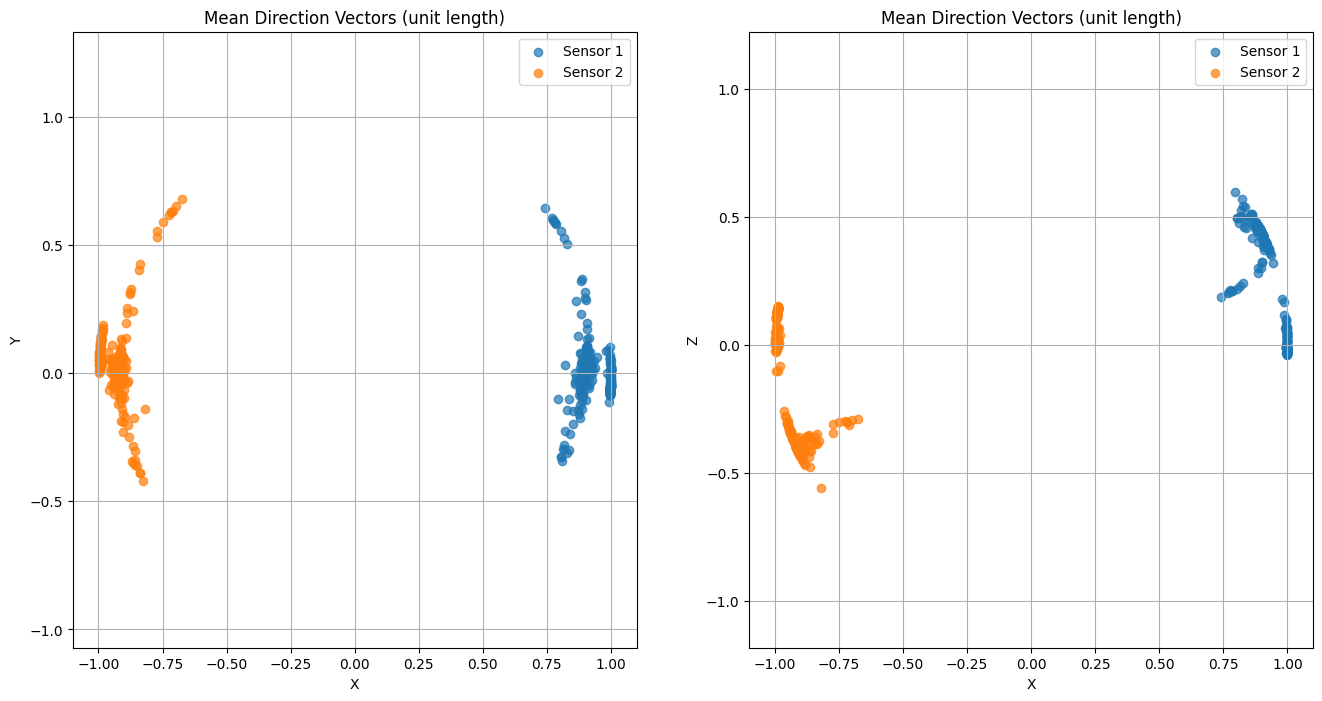

In [58]:
# Scatter plot of vectors
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(A_u[:, 0], A_u[:, 1], label="Sensor 1", alpha=0.7)
plt.scatter(B_u[:, 0], B_u[:, 1], label="Sensor 2", alpha=0.7)
plt.title("Mean Direction Vectors (unit length)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(A_u[:, 0], A_u[:, 2], label="Sensor 1", alpha=0.7)
plt.scatter(B_u[:, 0], B_u[:, 2], label="Sensor 2", alpha=0.7)
plt.title("Mean Direction Vectors (unit length)")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.axis("equal")
plt.grid()
plt.show()

In [66]:
# Optional: reject near-collinear poses (not informative)
# If all vectors are almost the same direction, yaw becomes ill-conditioned.
# Keep chunks with angle vs mean direction above some threshold.
mean_dir = normalize_rows(np.mean(A_u, axis=0, keepdims=True))[0]
cosang = np.clip(A_u @ mean_dir, -1.0, 1.0)
ang_deg = np.degrees(np.arccos(cosang))
keep = ang_deg > 10  # tune threshold (e.g. 5–15°)
A_u2, B_u2, w2 = A_u[keep], B_u[keep], weights[keep]

print(f"Using {len(A_u2)} chunks out of {len(A_u)} after filtering near-collinear poses")

Using 187 chunks out of 250 after filtering near-collinear poses


In [67]:
# Get the rotation vector
R_2_to_1 = kabsch_rotation(B_u2, A_u2, weights=w2)

# Apply to raw sensor2 samples (example for one chunk):
# s2_in_s1 = (R_2_to_1 @ s2[k].T).T

pred = (R_2_to_1 @ B_u.T).T
coserr = np.sum(pred * A_u, axis=1)
coserr = np.clip(coserr, -1.0, 1.0)
err_deg = np.degrees(np.arccos(coserr))
print("median err (deg):", np.median(err_deg))
print("p90 err (deg):", np.percentile(err_deg, 90))

# Save the rotation matrix for later use
np.save(f"accel_rotation_2_to_1_{log_filename}.npy", R_2_to_1)

median err (deg): 2.124991937647848
p90 err (deg): 3.241062825065175


In [ ]:
sensor2_in_sensor1 = (R_2_to_1 @ accel_filtered[1].T).T

[855.71721234  16.50041587 282.12937867]


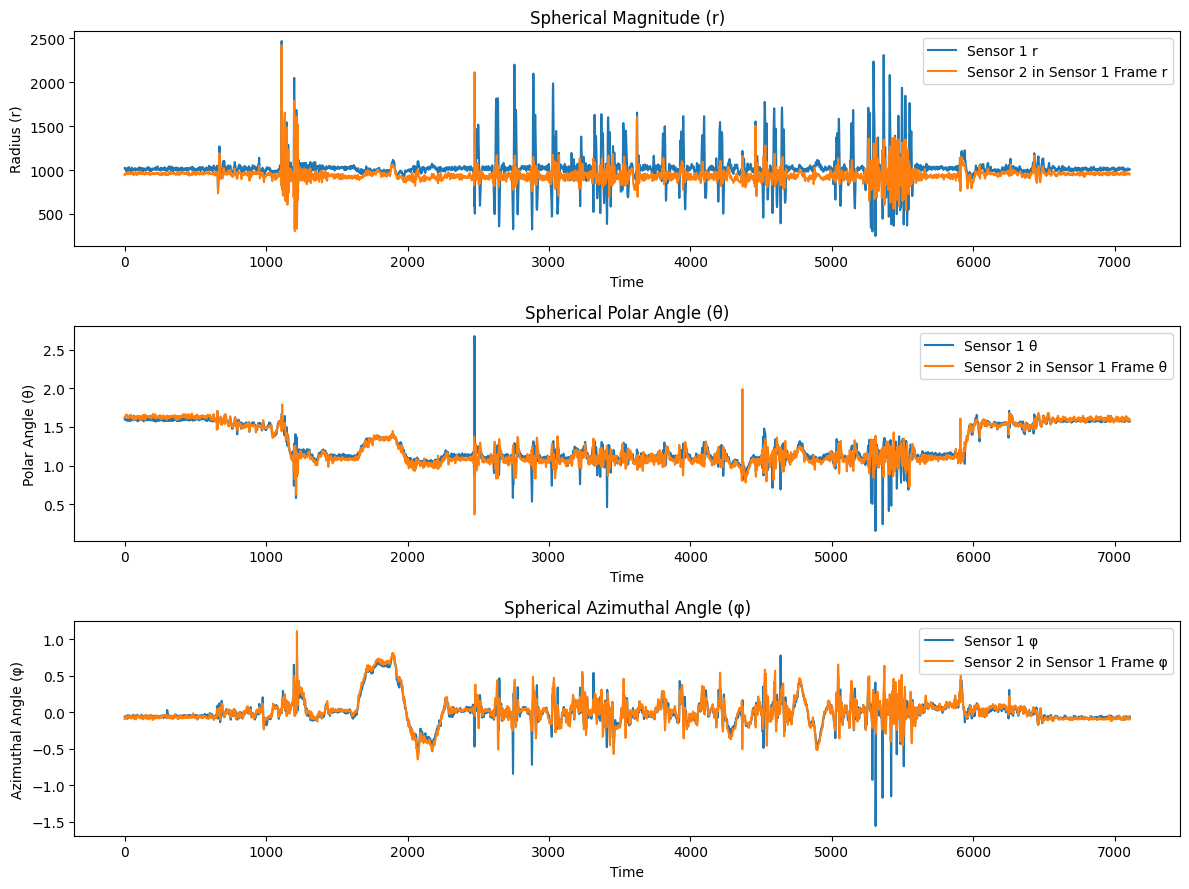

In [69]:
# Plotting the spherical components for both sensors
s1_spherical = np.array([get_spherical(*vec) for vec in accel_filtered[0]])
s2_in_s1_spherical = np.array([get_spherical(*vec) for vec in sensor2_in_sensor1])
def plot_sphericals(data1, data2, label1="Sensor 1", label2="Sensor 2"):
    plt.figure(figsize=(12, 9))
    plt.subplot(3, 1, 1)
    plt.plot(data1[:, 0], label=f"{label1} r")
    plt.plot(data2[:, 0], label=f"{label2} r")
    plt.title("Spherical Magnitude (r)")
    plt.xlabel("Time")
    plt.ylabel("Radius (r)")
    plt.legend()
    plt.subplot(3, 1, 2)
    plt.plot(data1[:, 1], label=f"{label1} θ")
    plt.plot(data2[:, 1], label=f"{label2} θ")
    plt.title("Spherical Polar Angle (θ)")
    plt.xlabel("Time")
    plt.ylabel("Polar Angle (θ)")
    plt.legend()
    plt.subplot(3, 1, 3)
    plt.plot(data1[:, 2], label=f"{label1} φ")
    plt.plot(data2[:, 2], label=f"{label2} φ")
    plt.title("Spherical Azimuthal Angle (φ)")
    plt.xlabel("Time")
    plt.ylabel("Azimuthal Angle (φ)")
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_sphericals(s1_spherical, s2_in_s1_spherical, label1="Sensor 1", label2="Sensor 2 in Sensor 1 Frame")

[-82.85918046   3.96271187  -6.19335628]


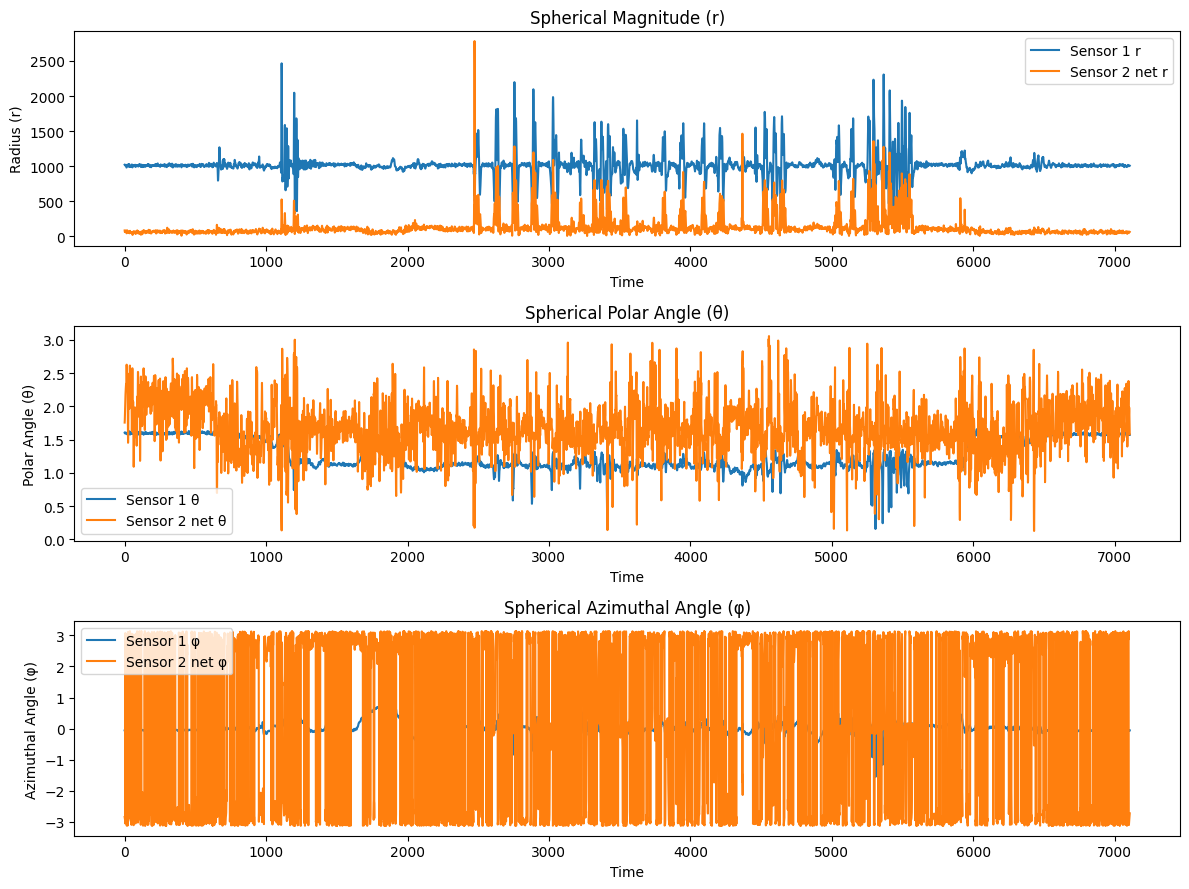

In [ ]:
# Net acceleration
s2_net_accel = sensor2_in_sensor1 - accel_filtered[0]
print(np.median(s2_net_accel, axis=0))

net_spherical = np.array([get_spherical(*vec) for vec in s2_net_accel])
plot_sphericals(s1_spherical, net_spherical, label1="Sensor 1", label2="Sensor 2 net")

Outliers: 125 / 250


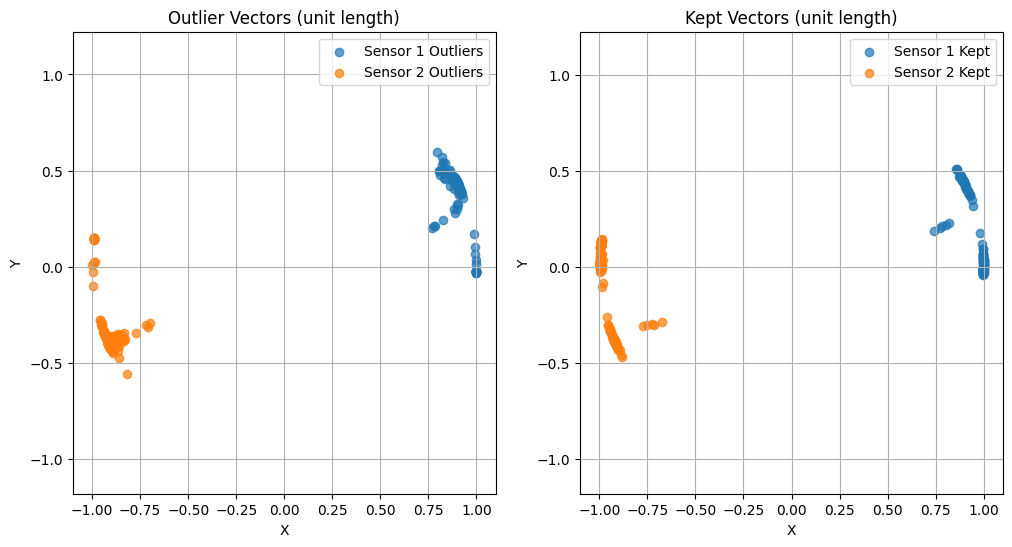

In [71]:
outliers = err_deg > np.percentile(err_deg, 50)
keep = ~outliers

print(f"Outliers: {np.sum(outliers)} / {len(err_deg)}")
A_u_outliers = A_u[outliers]
B_u_outliers = B_u[outliers]
A_u_keep = A_u[keep]
B_u_keep = B_u[keep]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(A_u_outliers[:, 0], A_u_outliers[:, 2], label="Sensor 1 Outliers", alpha=0.7)
plt.scatter(B_u_outliers[:, 0], B_u_outliers[:, 2], label="Sensor 2 Outliers", alpha=0.7)
plt.title("Outlier Vectors (unit length)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")
plt.grid()
plt.subplot(1, 2, 2)
plt.scatter(A_u_keep[:, 0], A_u_keep[:, 2], label="Sensor 1 Kept", alpha=0.7)
plt.scatter(B_u_keep[:, 0], B_u_keep[:, 2], label="Sensor 2 Kept", alpha=0.7)
plt.title("Kept Vectors (unit length)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.axis("equal")
plt.grid()
plt.show()

In [72]:
# Get angles
dirs = A_u
M = dirs @ dirs.T
ang = np.degrees(np.arccos(np.clip(M, -1, 1)))
print("median pairwise angle:", np.median(ang[np.triu_indices_from(ang,1)]))
print("p90 pairwise angle:", np.percentile(ang[np.triu_indices_from(ang,1)], 90))

median pairwise angle: 21.03832595162094
p90 pairwise angle: 32.19997443535355
